# Measure General SAE Metrics

## Imports

In [1]:
# print the current path
import os
print(os.getcwd())

# go to the parent directory
os.chdir('..')
# print the new current path
print(os.getcwd())

c:\Users\Grégoire\Documents\IRT\experiments
c:\Users\Grégoire\Documents\IRT


In [2]:
import urllib.request
from io import BytesIO
from PIL import Image

import torch
from torch.nn import functional as F

import numpy as np
from tqdm import tqdm

from src import metrics
from src.utils import (
    get_coco, get_laion, get_imagenet,
    _train,
    measure_everything, measure_bridge, get_bridge_norms,
)
import src.utils as utils
from src.utils import (
    plot_cosim_histogram, plot_pca, fit_and_plot_pca, _intervene,
    generate_visualization, linear_separability, data_classifiability
)

from matplotlib import pyplot as plt

device = "cuda:1" if torch.cuda.is_available() else "cpu"

c:\Users\Grégoire\Documents\IRT\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Definitions

In [3]:
use_model = "siglip2"

In [4]:
if use_model == "clip":
    model_name = "openai/clip-vit-base-patch32"
    d_model = 512
    beta = 4e-4
elif use_model == "clip-L":
    model_name = "openai/clip-vit-large-patch14"
    d_model = 768
    beta = 1e-4
elif use_model == "openclip":
    model_name="laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
    d_model = 512
    beta = 4e-4
elif use_model == "openclip-L":
    model_name="laion/CLIP-ViT-L-14-laion2B-s32B-b82K"
    d_model = 768
    beta = 2e-4
elif use_model == "siglip":
    model_name = "google/siglip-base-patch16-224"
    d_model = 768
    beta = 1e-4
elif use_model == "siglip2":
    model_name = "google/siglip2-base-patch16-224"
    d_model = 768
    beta = 7e-5
else:
    raise NotImplementedError(f"Model {use_model} not recognized.")

In [5]:
# laion_loader = get_laion(device=device, model_name=model_name, batch_size=512)
# # coco_loader = get_coco(device=device)
# # imagenet_test_loader, class_embeddings = get_imagenet(batch_size=512, model_name=model_name, device=device)
# # imagenet_train_loader, class_embeddings = get_imagenet(batch_size=512, model_name=model_name, device=device, split="train")

# train_loader = laion_loader

train_loader = None

In [6]:
modality_threshold = 0.05

In [7]:
SSAE, SSAE_name, _ = _train(beta=0, train_loader=train_loader, model_name=model_name, d_model=d_model, expansion_factor=8, archi="MP", device=device) # Standard SAE
ASAE, ASAE_name, _ = _train(beta=beta, train_loader=train_loader, model_name=model_name, d_model=d_model, expansion_factor=8, archi="MP", device=device)#, force_retrain=True, save_quand_meme=True) # Aligned SAE

Model name: google/siglip2-base-patch16-224/laion_MP_centered_False_8_L0_20_alpha00beta0.pt
Path trying to load : ./checkpoints/google/siglip2-base-patch16-224/laion_MP_centered_False_8_L0_20_alpha00beta0.pt
Model name: google/siglip2-base-patch16-224/laion_MP_centered_False_8_L0_20_alpha00beta7e-05.pt
Path trying to load : ./checkpoints/google/siglip2-base-patch16-224/laion_MP_centered_False_8_L0_20_alpha00beta7e-05.pt


## Energy & Bridge

In [7]:
SSAE.metrics = measure_everything(SSAE, train_loader, device, return_sqr=True)
ASAE.metrics = measure_everything(ASAE, train_loader, device, return_sqr=True)
print(f"Energy per concept: {ASAE.metrics.E[torch.argsort(ASAE.metrics.E, descending=True)[:10]]}")
print(f"Frequency per concept: {ASAE.metrics.f[torch.argsort(ASAE.metrics.E, descending=True)[:10]]}")
print(f"Modality score per concept: {ASAE.metrics.mu[torch.argsort(ASAE.metrics.E, descending=True)[:10]]}")

  0%|                                                                                          | 0/1393 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1393/1393 [00:10<00:00, 127.22it/s]


Energy per concept: tensor([0.1077, 0.0261, 0.0167, 0.0163, 0.0144, 0.0120, 0.0108, 0.0092, 0.0088,
        0.0080], device='cuda:1')
Frequency per concept: tensor([0.2463, 0.0630, 0.0527, 0.0380, 0.0358, 0.0337, 0.0344, 0.0234, 0.0221,
        0.0517], device='cuda:1')
Modality score per concept: tensor([1.2141e-05, 1.0000e+00, 1.1110e-05, 9.9998e-01, 9.9992e-01, 9.9969e-01,
        2.1116e-04, 9.9998e-01, 9.9997e-01, 4.6137e-01], device='cuda:1')


In [ ]:
utils.plot_energy_scatter_plotly(ASAE.metrics.E_Img, ASAE.metrics.E_Txt, ASAE_name)

./figures/google/siglip2-base-patch16-224/laion_MP_centered_False_8_L0_20_alpha00beta7e-05/energy/energy_scatter_plotly.html


In [11]:
# siglip :
img_highE = [
    366, 3160, 5780, 5626, 3146, 4824, 4712, 4042, 6143
]
img_lowE = [
    5523, 4028, 6017, 4064, 274, 1756, 3415
]
txt_highE = [
    1112, 3855, 3122, 5581,
]
txt_lowE = [
    5353, 6065, 4036, 3983, 2412, 5831, 697, 3138, 5895,
]
bi_idxs_highE = [
    1195, 2465, 991, 273, 2739, 1793, 4774, 5806, 2811, 4477, 858, 5899, 5163
]
bi_idxs_lowE = [
    3554, 352, 48, 4717, 3597, 5425, 3507, 5602, 2830, 1173, 2387, 4338, 4933, 229, 5797, 4182, 3525
]

In [ ]:
utils.feature_visualisation(ASAE, model_name, device, feature_idxs=img_highE)

In [ ]:
utils.feature_visualisation(ASAE, model_name, device, feature_idxs=img_lowE)

In [ ]:
utils.feature_visualisation(ASAE, model_name, device, feature_idxs=txt_highE)

In [ ]:
utils.feature_visualisation(ASAE, model_name, device, feature_idxs=txt_lowE)

In [ ]:
utils.feature_visualisation(ASAE, model_name, device, feature_idxs=bi_idxs_highE)#ASAE.metrics.E.argsort(descending=True)[:10])

In [ ]:
utils.feature_visualisation(ASAE, model_name, device, feature_idxs=bi_idxs_lowE)#ASAE.metrics.E.argsort(descending=True)[:10])

In [10]:
import importlib
import src.utils as utils
importlib.reload(utils)
img_url = "https://cdn11.bigcommerce.com/s-kc25pb94dz/images/stencil/1280w/products/188/602/1-Bunch-Bananas__30199.1650549450.jpg"
img = BytesIO(urllib.request.urlopen(img_url).read())
img = Image.open(img).convert("RGB")
utils.image_dissection_export_html(ASAE, model_name, device, img)

In [12]:
img_url = "https://icon2.cleanpng.com/20180520/ey/avqid03vo.webp"
img = BytesIO(urllib.request.urlopen(img_url).read())
img = Image.open(img).convert("RGB")
utils.image_dissection_export_html(ASAE, model_name, device, img)

In [13]:
img_url = "https://as1.ftcdn.net/jpg/01/04/01/40/1000_F_104014091_PuradJTVwG751A88jOruxVgHnHSU2jGI.jpg"
img = BytesIO(urllib.request.urlopen(img_url).read())
img = Image.open(img).convert("RGB")
utils.image_dissection_export_html(ASAE, model_name, device, img)

In [21]:
importlib.reload(utils)
img_url = "https://t4.ftcdn.net/jpg/09/69/46/43/360_F_969464328_BsABgg6gLMxYgY3iL74cuteW7s2YrMTP.jpg"
img = BytesIO(urllib.request.urlopen(img_url).read())
img = Image.open(img).convert("RGB")
utils.image_dissection_export_html(ASAE, model_name, device, img)

In [20]:
importlib.reload(utils)
img_url = "https://images.netdirector.co.uk/gforces-auto/image/upload/q_auto,c_fill,f_auto,fl_lossy,w_1920,h_1080/auto-client/b847ea2936f676aa063afbf574cb181f/612108.jpg"
img = BytesIO(urllib.request.urlopen(img_url).read())
img = Image.open(img).convert("RGB")
utils.image_dissection_export_html(ASAE, model_name, device, img)

In [15]:
img_url = "https://cdn.actronics.nl/image/mclaren-720s-mauvine-blue_60ba3dabbc594.jpg"
img = BytesIO(urllib.request.urlopen(img_url).read())
img = Image.open(img).convert("RGB")
utils.image_dissection_export_html(ASAE, model_name, device, img)

In [ ]:
SSAE_bridge = {
    "bridge_sigma" : measure_bridge(SSAE, train_loader, SSAE.metrics.E, SSAE.metrics.E_Img, SSAE.metrics.E_Txt, device, center=False, normalize=False, null_C=False, null_D=False).cpu().detach(),
    "bridge_gamma" : measure_bridge(SSAE, train_loader, SSAE.metrics.E, SSAE.metrics.E_Img, SSAE.metrics.E_Txt, device, center=False, normalize=False, null_C=False, null_D=False, weight_type="OT").cpu().detach(),
}
ASAE_bridge = {
    "bridge_sigma" : measure_bridge(ASAE, train_loader, ASAE.metrics.E, ASAE.metrics.E_Img, ASAE.metrics.E_Txt, device, center=False, normalize=False, null_C=False, null_D=False).cpu().detach(),
    "bridge_gamma" : measure_bridge(ASAE, train_loader, ASAE.metrics.E, ASAE.metrics.E_Img, ASAE.metrics.E_Txt, device, center=False, normalize=False, null_C=False, null_D=False, weight_type="OT").cpu().detach(),
}

100%|██████████████████████████████████████████████████████████████████████████████| 1393/1393 [00:10<00:00, 129.17it/s]


Optimal transport cost: 6.10e-01


100%|██████████████████████████████████████████████████████████████████████████████| 1393/1393 [00:10<00:00, 131.02it/s]


Optimal transport cost: 5.12e-01


In [ ]:
get_bridge_norms(SSAE_bridge["bridge_sigma"], SSAE)
get_bridge_norms(ASAE_bridge["bridge_sigma"], ASAE)

In [ ]:
print(SSAE.metrics)
print(ASAE.metrics)

{mu_std_arround_05: 0.45261821150779724, E_in_T: 0.35913373833818485, E_in_I: 0.3947737026718524, E_in_B: 0.24609259368483868, mu_B_std_arround_05: 0.4594299793243408}
{mu_std_arround_05: 0.3818817436695099, E_in_T: 0.24871322088649855, E_in_I: 0.27017723224428364, E_in_B: 0.4811095468692178, mu_B_std_arround_05: 0.2846468687057495}


## Geometric Analysis

#### 0. Unimodal "Biases"

tensor(0.8411, device='cuda:1')
tensor(0.2009, device='cuda:1')
11
(11, 512)
Total Frequency : 0.46058976650238037
0.9555307


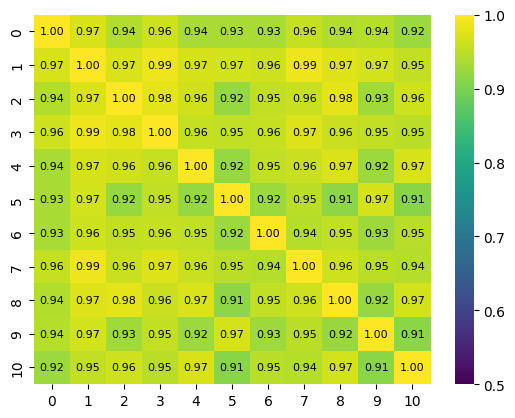

tensor(0.8411, device='cuda:1')
tensor(0.1820, device='cuda:1')
26
(26, 512)
Total Frequency : 0.4195464849472046
0.8197802


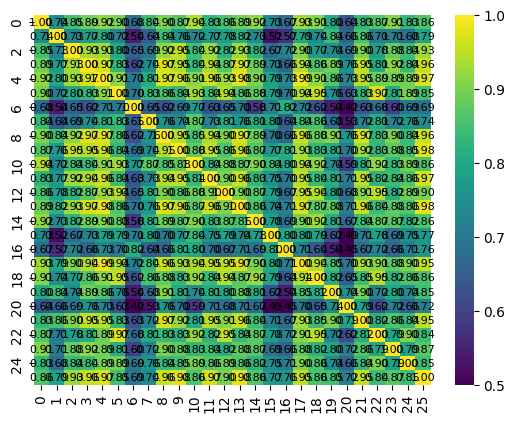

In [59]:
D = ASAE.dictionary._fused_dictionary.cpu().detach().numpy()
mu = ASAE.metrics.mu.cpu().numpy()
f = ASAE.metrics.f
E = ASAE.metrics.E.cpu().numpy()
eps = 1e-3
mask = (mu <= eps) & (E > 1e-3)
print(ASAE.metrics.E.sum())
print(ASAE.metrics.E[mask].sum()/ASAE.metrics.E.sum())
print(mask.sum())
D = D[mask]
f = f[mask]
print(D.shape)
print(f"Total Frequency : {f.sum().item()}")
DDT = D @ D.T
print(DDT.mean())
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(DDT, vmin=0.5, vmax=1, annot=True, fmt=".2f", cmap='viridis', cbar=True,
            annot_kws={"size": 8, "color": "black", "ha": "center", "va": "center"})
plt.show()

D = ASAE.dictionary._fused_dictionary.cpu().detach().numpy()
mu = ASAE.metrics.mu.cpu().numpy()
f = ASAE.metrics.f
E = ASAE.metrics.E.cpu().numpy()
eps = 1e-3
mask = (mu >= (1- eps)) & (E > 1e-3)
print(ASAE.metrics.E.sum())
print(ASAE.metrics.E[mask].sum()/ASAE.metrics.E.sum())
print(mask.sum())
D = D[mask]
f = f[mask]
print(D.shape)
print(f"Total Frequency : {f.sum().item()}")
DDT = D @ D.T
print(DDT.mean())
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(DDT, vmin=0.5, vmax=1, annot=True, fmt=".2f", cmap='viridis', cbar=True,
            annot_kws={"size": 8, "color": "black", "ha": "center", "va": "center"})
plt.show()

#### 1. Cosim Histograms & Data Projections

In [8]:
I = train_loader.dataset.tensors[0].cpu()
T = train_loader.dataset.tensors[1].cpu()
D_ict = torch.cat([I.cpu(), T.cpu()], dim=0)
I_mu = I.mean(dim=0)
T_mu = T.mean(dim=0)
D_mu = (I_mu + T_mu) / 2

In [ ]:
# plot_cosim_histogram(I, T, SSAE_name)
import importlib
import src.utils as utils
importlib.reload(utils)
utils.plot_cosim_histogram(I, T, ASAE_name)

In [14]:
# Plot "PCA"s of D, but not on the top 2 PCs, instead on (1) D_mu, (2) I_mu - T_mu

d1 = D_mu.cpu().numpy()
d1 = d1 / np.linalg.norm(d1)
d2 = I_mu.cpu().numpy() - T_mu.cpu().numpy()
d2 = d2 / np.linalg.norm(d2)

plot_pca(D_ict, d1, d2, I_mu, T_mu, D_mu, title='Projection of D on d1 = D_mu and d2 = I_mu - T_mu', save_title='data_pca_d1_d2', sae_name=SSAE_name)
plot_pca(D_ict, d1, d2, I_mu, T_mu, D_mu, title='Projection of D on d1 = D_mu and d2 = I_mu - T_mu', save_title='data_pca_d1_d2', sae_name=ASAE_name)

fit_and_plot_pca(I, T, D_ict, SSAE_name)
fit_and_plot_pca(I, T, D_ict, ASAE_name)


In [10]:
I_bi_S, T_bi_S, _ = _intervene(SSAE, train_loader, SSAE.metrics.mu, device, return_D=False)
# plot_cosim_histogram(I_bi_S, T_bi_S, B_bi_S, SSAE_name, subtitle="Unimodal concepts removed")
I_bi_A, T_bi_A, _ = _intervene(ASAE, train_loader, ASAE.metrics.mu, device, return_D=False)
# plot_cosim_histogram(I_bi_A, T_bi_A, B_bi_A, ASAE_name, subtitle="Unimodal concepts removed")

100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [00:14<00:00, 98.09it/s]


In [ ]:
utils.plot_cosim_histogram(I_bi_A, T_bi_A, ASAE_name)

In [16]:
B_bi_S = torch.cat([I_bi_S.cpu(), T_bi_S.cpu()], dim=0).cpu()
B_bi_A = torch.cat([I_bi_A.cpu(), T_bi_A.cpu()], dim=0).cpu()
fit_and_plot_pca(I_bi_S, T_bi_S, B_bi_S, SSAE_name, save_title='data_proj_pca_pc1_pc2')
fit_and_plot_pca(I_bi_A, T_bi_A, B_bi_A, ASAE_name, save_title='data_proj_pca_pc1_pc2')

#### 3. Dictionary Atoms Linear Separability

/home/gregoire.dhimoila/test/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of lines: 3234


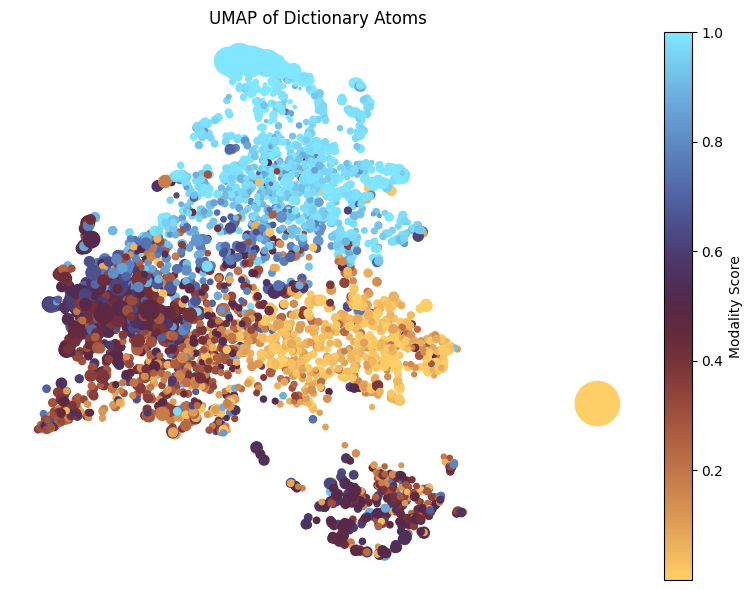

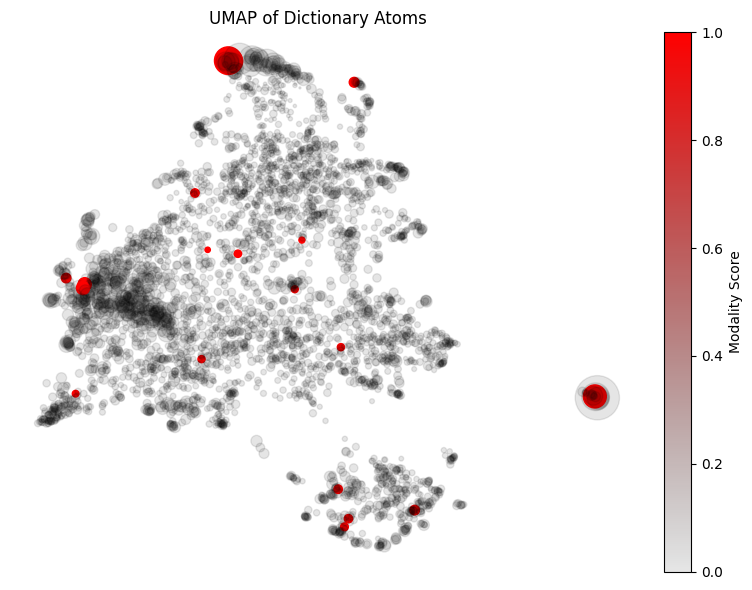

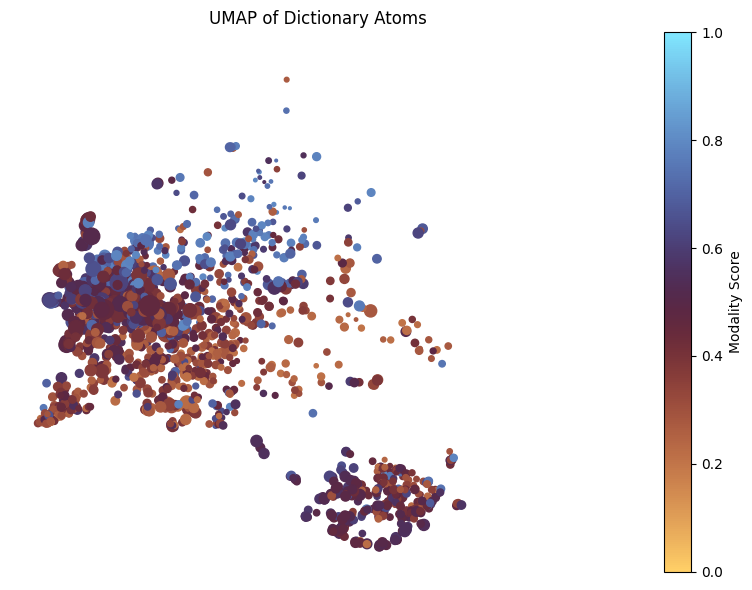

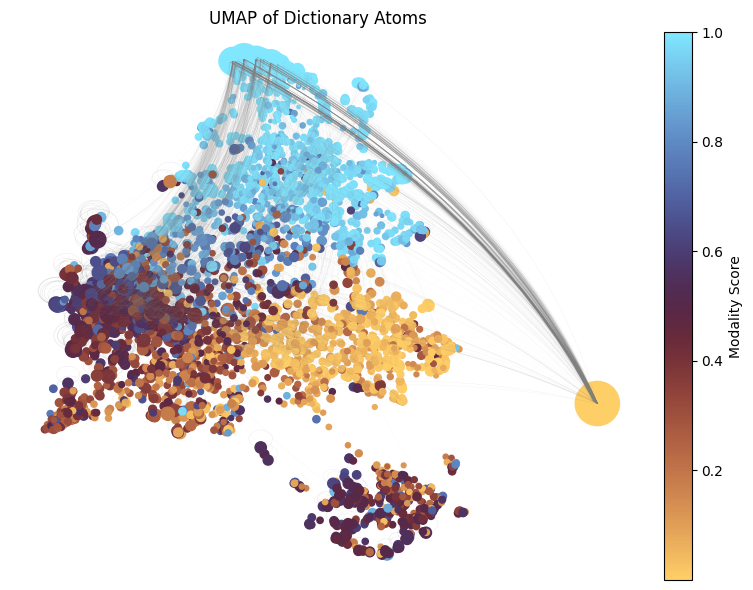

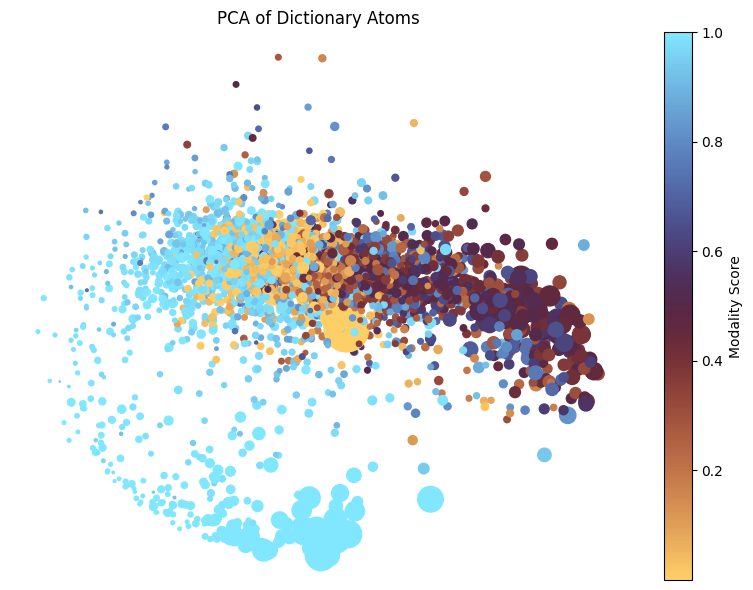

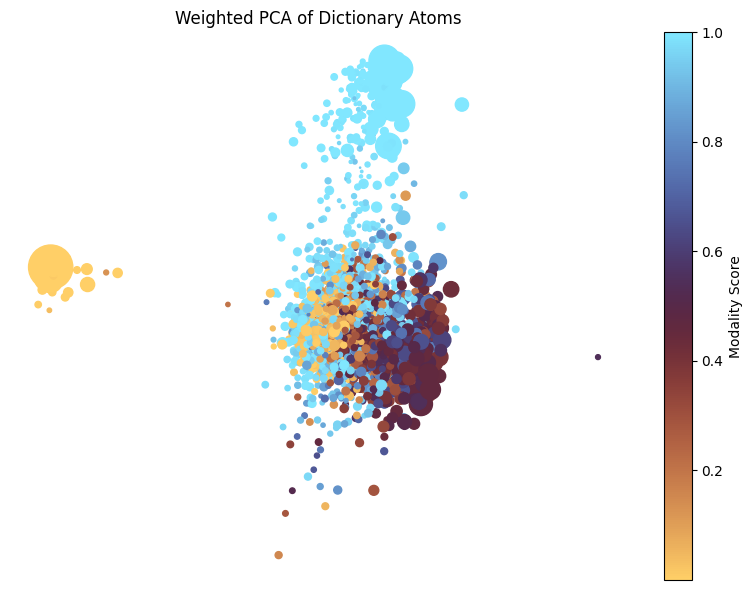

In [ ]:
generate_visualization(SSAE, SSAE_name, SSAE.metrics.mu, SSAE.metrics.E, SSAE.metrics.f, SSAE_bridge["bridge_sigma"])
generate_visualization(ASAE, ASAE_name, ASAE.metrics.mu, ASAE.metrics.E, ASAE.metrics.f, ASAE_bridge["bridge_sigma"])

##### 3.1. Features classifying features

In [ ]:
linear_separability(SSAE, SSAE_name, eps=modality_threshold)

In [ ]:
linear_separability(ASAE, ASAE_name, eps=modality_threshold)

##### 3.2. Features classifying Data

In [ ]:
data_classifiability(SSAE, I, T, SSAE_name, eps=modality_threshold)

In [ ]:
data_classifiability(ASAE, I, T, ASAE_name, eps=modality_threshold)

##### 3.3. Dictionary orthogonality : $D_I \bot D_T \bot D_B$

In [22]:
def get_dict_orthogonality(sae, modality_score):
    D = sae.dictionary._fused_dictionary.cpu().numpy()
    D = D / np.linalg.norm(D, axis=1, keepdims=True)  # Normalize each vector to unit length
    orthogonality = (np.dot(D, D.T))
    I_mask = (modality_score > 0.9).cpu().numpy()
    T_mask = (modality_score < 0.1).cpu().numpy()
    B_mask = (modality_score <= 0.9).cpu().numpy() & (modality_score >= 0.1).cpu().numpy()
    sae.metrics._add_more({
        'orthogonality': {
            'I_ortho_T': orthogonality[I_mask][:, T_mask].mean(),
            'I_ortho_B': orthogonality[I_mask][:, B_mask].mean(),
            'T_ortho_B': orthogonality[T_mask][:, B_mask].mean(),
            'I_ortho_I': orthogonality[I_mask][:, I_mask].mean(),
            'T_ortho_T': orthogonality[T_mask][:, T_mask].mean(),
            'B_ortho_B': orthogonality[B_mask][:, B_mask].mean(),
        }
    }, save=True)

In [23]:
get_dict_orthogonality(SSAE, SSAE.metrics.mu)
get_dict_orthogonality(ASAE, ASAE.metrics.mu)

#### 4. Modality Gap & Contrastive Loss

In [24]:
@torch.no_grad()
def get_modality_gap(I, T, sae, data_name="default"):
    # Measure the modality gap :
    # - norm of difference in mean image and text embeddings
    # - wasserstein distance between the image and text embeddings distributions.
    N_subsample = int(1e4) # dataset has 1e6 images and texts, subsample to 1e4 for speed.
    # raise
    # # TODO : try modality gap wasserstein without 
    p1 = torch.randperm(I.shape[0])[:N_subsample]
    p2 = torch.randperm(T.shape[0])[:N_subsample]
    T = T[p2].cpu()
    I = I[p1].cpu() # shape (N_subsample, D)
    I_mean = I.mean(axis=0) # shape (D,)
    T_mean = T.mean(axis=0)
    DiM = np.linalg.norm(I_mean - T_mean)
    c = metrics.Wasserstein(I, T, metric='cosim')
    print(f"Modality Gap: DiM: {DiM}, OT cost: {c}")
    sae.metrics._add_more({
        f"modality_gap_{data_name}": {
            "DiM": DiM,
            "Wasserstein": c,
        }
    }, save=True)

def get_contrastive_loss(I, T, sae, data_name="default"):
    # Track Contrastive Loss & accuracy for Image-Text pairs
    # TODO : retrain the logit_scale parameter to fit the data
    batch_size = 256
    num_batches = I.shape[0] // batch_size

    class LogitScale(torch.nn.Module):
        def __init__(self, initial_value=4.6052):
            super(LogitScale, self).__init__()
            self.logit_scale = torch.nn.Parameter(torch.tensor(initial_value))

        def forward(self, x):
            return torch.exp(self.logit_scale) * x
    logit_scale = LogitScale()
    optimizer = torch.optim.Adam(logit_scale.parameters(), lr=1e-3)

    for ep in range(1, 3):
        contrastive_loss = 0.0
        correct_pairs = 0
        total_pairs = 0
        p = 0
        for i in tqdm(range(num_batches)):
            I_batch = I[i * batch_size:(i + 1) * batch_size]
            T_batch = T[i * batch_size:(i + 1) * batch_size]

            # Compute cosine similarity
            I_batch = I_batch / (I_batch.norm(dim=1, keepdim=True) + 1e-8)
            T_batch = T_batch / (T_batch.norm(dim=1, keepdim=True) + 1e-8)
            logits_per_image = I_batch @ T_batch.T
            logits_per_text = T_batch @ I_batch.T

            # logit_scale = torch.exp(torch.tensor(4.6052)) # from CLIP ViT-B/32

            logits_per_image = logit_scale(logits_per_image)
            logits_per_text = logit_scale(logits_per_text)

            labels = torch.arange(batch_size, device=I_batch.device)
            loss_image = F.cross_entropy(logits_per_image, labels)
            loss_text = F.cross_entropy(logits_per_text, labels)
            loss = (loss_image + loss_text) / 2
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            contrastive_loss += loss.item()

            acc_image = (logits_per_image.argmax(dim=1) == labels).sum().item()
            acc_text = (logits_per_text.argmax(dim=1) == labels).sum().item()
            correct_pairs += (acc_image + acc_text) / 2
            total_pairs += batch_size

            # p : probability of correct labels
            p_image = torch.softmax(logits_per_image, dim=1)
            p_image = p_image[torch.arange(batch_size, device=I_batch.device), labels].mean().item()
            p_text = torch.softmax(logits_per_text, dim=1)
            p_text = p_text[torch.arange(batch_size, device=I_batch.device), labels].mean().item()
            p += (p_image + p_text) / 2
        contrastive_loss /= num_batches
        accuracy = correct_pairs / total_pairs
        print(f"Contrastive Loss: {contrastive_loss:.4f}, Accuracy: {accuracy:.4f}, Probability: {p / num_batches:.4f}")
    sae.metrics._add_more({
        f"contrastive_loss_{data_name}": {
            "loss": contrastive_loss,
            "accuracy": accuracy,
            "probability": p / num_batches,
        }
    }, save=True)

In [25]:
get_modality_gap(train_loader.dataset.tensors[0], train_loader.dataset.tensors[1], SSAE)
get_modality_gap(train_loader.dataset.tensors[0], train_loader.dataset.tensors[1], ASAE)

get_contrastive_loss(train_loader.dataset.tensors[0], train_loader.dataset.tensors[1], SSAE)
get_contrastive_loss(train_loader.dataset.tensors[0], train_loader.dataset.tensors[1], ASAE)

In [26]:
get_modality_gap(I_bi_S, T_bi_S, SSAE, data_name="bimodal")
get_modality_gap(I_bi_A, T_bi_A, ASAE, data_name="bimodal")

get_contrastive_loss(I_bi_S, T_bi_S, SSAE, data_name="bimodal")
get_contrastive_loss(I_bi_A, T_bi_A, ASAE, data_name="bimodal")

del I_bi_S, T_bi_S, I_bi_A, T_bi_A

In [27]:
I_ae_S, T_ae_S, _ = _intervene(SSAE, train_loader, SSAE.metrics.mu, device, eps=0.0, return_D=False)
I_ae_A, T_ae_A, _ = _intervene(ASAE, train_loader, ASAE.metrics.mu, device, eps=0.0, return_D=False)

# plot_cosim_histogram(I_ae_S, T_ae_S, B_ae_S, SSAE_name, subtitle="AE")
# plot_cosim_histogram(I_ae_A, T_ae_A, B_ae_A, ASAE_name, subtitle="AE")
# fit_and_plot_pca(I_ae_S, T_ae_S, B_ae_S, SSAE_name, save_title='data_ae_pca_pc1_pc2')
# fit_and_plot_pca(I_ae_A, T_ae_A, B_ae_A, ASAE_name, save_title='data_ae_pca_pc1_pc2')
get_modality_gap(I_ae_S, T_ae_S, SSAE, data_name="AE")
get_modality_gap(I_ae_A, T_ae_A, ASAE, data_name="AE")
get_contrastive_loss(I_ae_S, T_ae_S, SSAE, data_name="AE")
get_contrastive_loss(I_ae_A, T_ae_A, ASAE, data_name="AE")

del I_ae_S, T_ae_S, I_ae_A, T_ae_A

In [28]:
I_uni_S, T_uni_S, _ = _intervene(SSAE, train_loader, SSAE.metrics.mu, device, complement=True, return_D=True)
I_uni_A, T_uni_A, _ = _intervene(ASAE, train_loader, ASAE.metrics.mu, device, complement=True, return_D=True)
get_modality_gap(I_uni_S, T_uni_S, SSAE, data_name="unimodal")
get_modality_gap(I_uni_A, T_uni_A, ASAE, data_name="unimodal")

get_contrastive_loss(I_uni_S, T_uni_S, SSAE, data_name="unimodal")
get_contrastive_loss(I_uni_A, T_uni_A, ASAE, data_name="unimodal")

del I_uni_S, T_uni_S, I_uni_A, T_uni_A

In [29]:
print(SSAE.metrics)
print(ASAE.metrics)

# torch.save(SSAE.metrics, f"./figures/{SSAE_name.replace('.pt', '')}/metrics.pt")
# torch.save(ASAE.metrics, f"./figures/{ASAE_name.replace('.pt', '')}/metrics.pt")

## Modality Gap
### CLIP
- Default : 0.72
- SAE
    - AE : 0.72
    - Bi : 0.04
    - Uni : 0.72
- SAE-A
    - AE : 0.72
    - Bi : 0.04
    - Uni : 0.72

### OpenCLIP
- Default : 0.51
- SAE
    - AE : 0.51
    - Bi : 0.07
    - Uni : 0.53
- SAE-A
    - AE : 0.51
    - Bi : 0.06
    - Uni : 0.49

### SIGLIP
- Default : 0.97
- SAE
    - AE : 0.97
    - Bi : 0.032
    - Uni : 1.08
- SAE-A
    - AE : 0.97
    - Bi : 0.026
    - Uni : 1.09

### SIGLIP2
- Default : 1.08
- SAE
    - AE : 1.08
    - Bi : 0.04
    - Uni : 1.09
- SAE-A
    - AE : 1.08
    - Bi : 0.05
    - Uni : 1.09



## Recall
### CLIP
- Default : 0.96
- SAE
    - AE : 0.92
    - Bi : 0.70
    - Uni : 0.17
- SAE-A
    - AE : 0.88
    - Bi : 0.76
    - Uni : 0.006

### OpenCLIP
- Default : 0.98
- SAE
    - AE : 0.95
    - Bi : 0.91
    - Uni : 0.02
- SAE-A
    - AE : 0.95
    - Bi : 0.93
    - Uni : 0.007

### SIGLIP
- Default : 0.96
- SAE
    - AE : 0.91
    - Bi : 0.88
    - Uni : 0.02
- SAE-A
    - AE : 0.91
    - Bi : 0.9010
    - Uni : 0.007

### SIGLIP2
- Default : 0.36
- SAE
    - AE : 0.30
    - Bi : 0.29
    - Uni : 0.02
- SAE-A
    - AE : 0.30
    - Bi : 0.31
    - Uni : 0.01